## Fixed parameter search

This notebook is intendend to find the best matching values for fixed parameters to be used in the simulation.

These parameters include:
- Distribution of time between orders.
    - Probably exponential distribution, extension of Poisson dist
- Distribution of token size of trades
    - Possibly different for buy and sell orders
- Buy or Sell order
    - Some function of past X trades completed. This is undecided yet.

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from scipy.stats import kstest, expon

pair_list = [
            ("AGIX-WETH", "https://www.dextools.io/app/en/ether/pair-explorer/0xe45b4a84e0ad24b8617a489d743c52b84b7acebe", 40),
            ("HEX-WETH", "https://www.dextools.io/app/en/ether/pair-explorer/0x55d5c232d921b9eaa6b37b5845e439acd04b4dba", 100),
            ("OPTIMUS-WETH", "https://www.dextools.io/app/en/ether/pair-explorer/0x8de7a9540e0edb617d78ca5a7c6cc18295fd8bb9", 70),
            ("SHIB-WETH", "https://www.dextools.io/app/en/ether/pair-explorer/0x811beed0119b4afce20d2583eb608c6f7af1954f", 50),
            ("SHIK-WETH", "https://www.dextools.io/app/en/ether/pair-explorer/0x0b9f5cef1ee41f8cccaa8c3b4c922ab406c980cc", 60),
            ("BabyDoge-WBNB", "https://www.dextools.io/app/en/bnb/pair-explorer/0xc736ca3d9b1e90af4230bd8f9626528b3d4e0ee0", 180),
            ("FLOKI-WBNB", "https://www.dextools.io/app/en/bnb/pair-explorer/0x231d9e7181e8479a8b40930961e93e7ed798542c", 180),
            ("INJ-WBNB", "https://www.dextools.io/app/en/bnb/pair-explorer/0x1bdcebca3b93af70b58c41272aea2231754b23ca", 60),
            ("MBOX-WBNB", "https://www.dextools.io/app/en/bnb/pair-explorer/0x8fa59693458289914db0097f5f366d771b7a7c3f", 90),
            ("VOLT-WBNB", "https://www.dextools.io/app/en/bnb/pair-explorer/0x487bfe79c55ac32785c66774b597699e092d0cd9", 200)
            ]

In [3]:
def load_csv_to_df(file_path, verbose=False, name=""):
    # Load CSV file into a DataFrame
    df = pd.read_csv(file_path)
    
    # If verbose mode is enabled, print the dataset name, number of rows, and some datetime information
    if verbose:
        #print(name)
        print("Number of rows:", len(df))
        print("Last datetime:", df.datetime.iloc[-2], )  # Assuming there is a "datetime" column in the DataFrame
        print("First datetime:", df.datetime.iloc[0])
        print("Time difference (in days):", datetime.strptime(df.datetime.iloc[0], '%Y-%m-%d %H:%M:%S') - datetime.strptime(df.datetime.iloc[-5], '%Y-%m-%d %H:%M:%S'))
        print()
    
    # Return the DataFrame
    return df

def set_index(df, info=False):
    # Convert 'datetime' column to datetime type and set it as the index
    df['datetime'] = pd.to_datetime(df['datetime'])
    df.set_index('datetime', inplace=True)
    
    if info:
        # Print some information about the resulting DataFrame
        df.info()

(0.0, 398.22149302707135)
The p-value is: 2.9499821085170385e-78


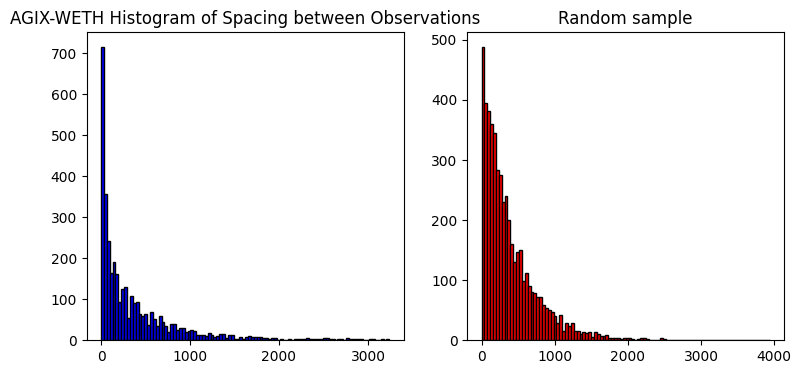

(0.0, 95.83093899646055)
The p-value is: 8.782902442928636e-233


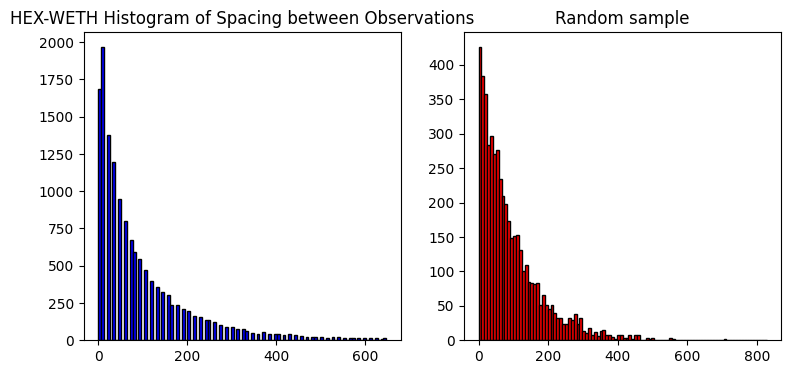

(0.0, 153.3993220338983)
The p-value is: 1.1583765150260035e-89


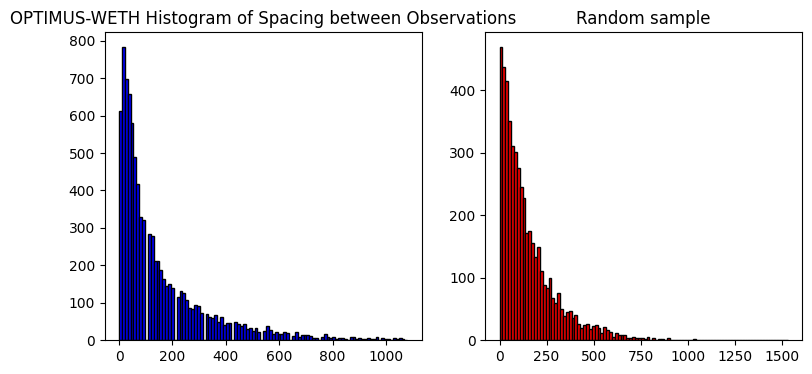

(0.0, 306.1414913957935)
The p-value is: 2.5026877755547673e-24


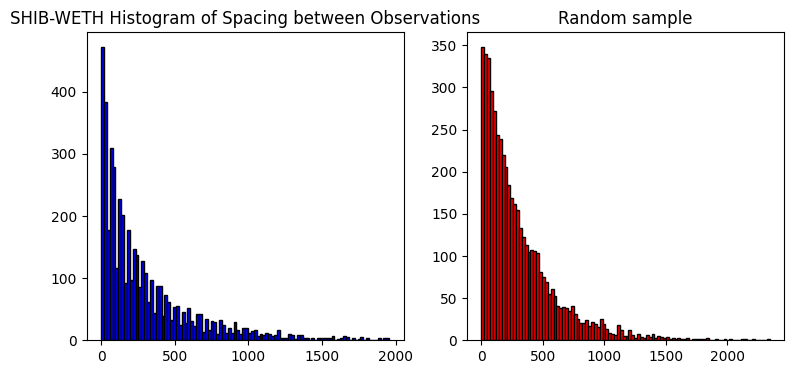

(0.0, 335.943754394188)
The p-value is: 8.159555574864756e-73


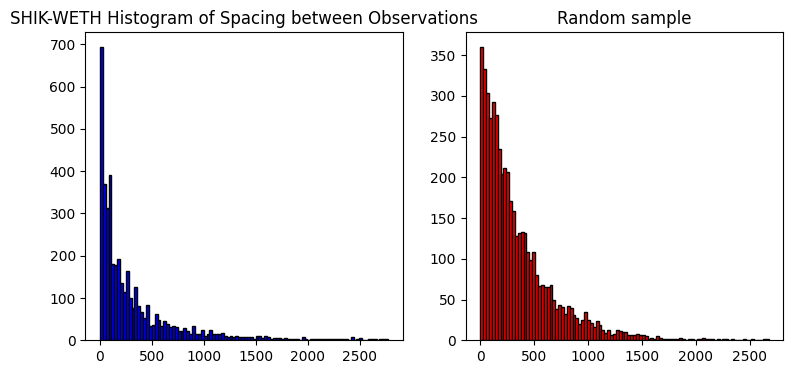

(0.0, 68.75762721148052)
The p-value is: 7.15643817119833e-74


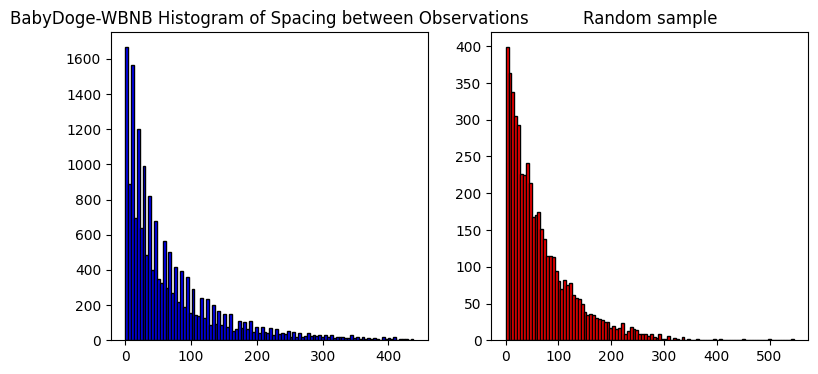

(0.0, 44.877010877891834)
The p-value is: 0.0


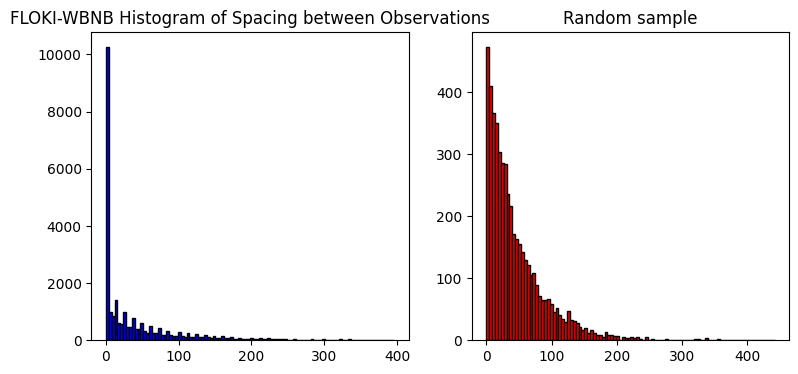

(0.0, 185.54828744123571)
The p-value is: 0.0


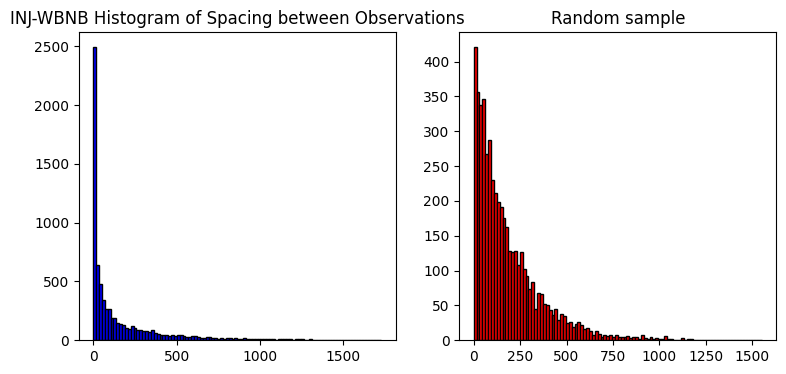

(0.0, 103.46294594368786)
The p-value is: 0.0


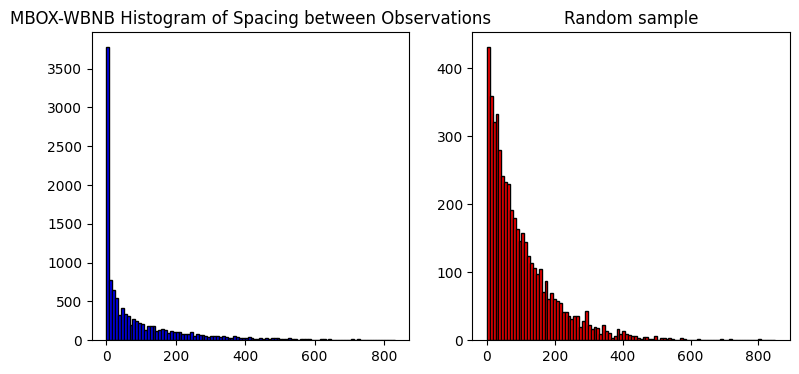

(0.0, 60.60467855940761)
The p-value is: 0.0


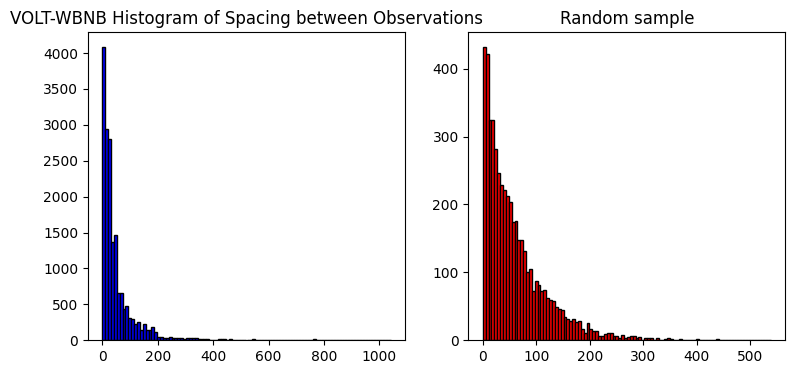

In [36]:
##Part 1 - The time spacing

for pair in pair_list:
    #geting name of current pair and folder location
    name = pair[0]
    # if name == "FLOKI-WBNB":
    #     continue
    # print(f"~~~---{name}---~~~")
    file_path = f"D:/Dokumenty/Vejška/Magisterské studium/DIPLOMKA/Code_and_Data/Data_scraping/DEX_data_scraper/complete_data/{name}/{name}_complete.csv"

    #loading data without werbose printout, seting index
    df = load_csv_to_df(file_path, verbose=False, name = name)
    set_index(df, info=False)


    #compute the spacing between variables
    spacing = np.diff(df.index).astype('timedelta64[s]').astype(int) *-1

    #Cropping data to 99th percentile
    percentile_99 = np.percentile(spacing, 99)
    spacing_99 = [val for val in spacing if val <= percentile_99]

    plot_hist = True
    if plot_hist:
        pass
        # # Plot histogram
        # plt.hist(spacing_99, bins=100, edgecolor='black')
        # #plt.xlim(0, 20)
        # plt.xlabel('Spacing between observations (seconds)')
        # plt.ylabel('Frequency')
        # plt.title(name + ' Histogram of Spacing between Observations')
        # plt.show()

    param = expon.fit(spacing_99)
    print(param)

    statistic, p_value = kstest(spacing_99, 'expon', args=param)

    # Print the p-value
    print("The p-value is:", p_value)

    #Try to compare data with random sample fro fitted distributions
    r = expon.rvs(loc=param[0], scale=param[1], size=5000)
    if plot_hist:
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
        axes[0].hist(spacing_99, bins=100, color='blue', edgecolor='black')
        axes[0].set_title(f'{name} Histogram of Spacing between Observations')

        axes[1].hist(r, bins=100, color='red', edgecolor='black')
        axes[1].set_title('Random sample')
        
        #plt.hist(spacing_99, bins=100, edgecolor='black')
        plt.show()


        #Here to continue, perhaps try an automated search over all distributions...somewhere 
        #I saw a list of all distribution names.
    

In [20]:
from scipy.stats import kstest, expon

# Your data in a Python list
#data = [1.2, 3.4, 5.6, ...]

# Fit an exponential distribution to the data using MLE
param = expon.fit(spacing)

# Test for goodness-of-fit using Kolmogorov-Smirnov test
statistic, p_value = kstest(spacing, 'expon', args=param)

# Print the p-value
print("The p-value is:", p_value)

The p-value is: 0.0
